Info here

# Imports

In [9]:
import loompy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import scipy
from astropy.stats import RipleysKEstimator
import networkx as nx
from itertools import permutations as permute

%matplotlib notebook

# Functions

In [2]:
def heat_map(df, labels, sort=None, cluster_colors=None, cluster_number = False, save=False, name=''):
    """
    Plot heat_map of a dataframe.
    Input:
    `df`(pandas dataframe): Dataframe to plot. Cells as columns, genes as rows.
    `labels`(list/array): list of labels of the cells in the same order as the 
        df columns.
    `sort`(list): List of sorted cluster numbers. If None it will plot them in
        assending order
    `cluster_colors`(dict): Dictionary matching cluster numbers with colors
        in the hex fomat. Like '#ff0000' for red
    `cluster_number`(bool): Show cluster numbers in the top color bar. Usefull
        when manually sorting the clusters.
    `save`(bool): option to save the figure as png with 300dpi.
    `name`(str): Name to use when saving
    
    """
    #Find the name of the input df, for logging
    df_input_name =[x for x in globals() if globals()[x] is df][0]
    print('df used for plot: {}'.format(df_input_name))
    
    if sort == None:
        optimal_order = np.unique(labels)    
    else:
        optimal_order = sort
    print('Order of clusters: {}'.format(optimal_order))
    
    cl, lc = gen_labels(df, np.array(labels))[:2]
    
    #Sort the cells according to the optimal cluster order
    optimal_sort_cells = sum([lc[i] for i in optimal_order], [])
    
    #Create a list of optimal sorted cell labels
    optimal_sort_labels = [cl[i] for i in optimal_sort_cells]
    
    fig, axHM = plt.subplots(figsize=(9,5))
    
    df_full = df.copy() # _fish_log
    z = df_full.values
    z = z/np.percentile(z, 99, 1)[:,None]
    z = pd.DataFrame(z, index=df_full.index, columns=df_full.columns)
    z = z.loc[:,optimal_sort_cells].values
    
    im = axHM.pcolormesh(z, cmap='viridis', vmax=1)
    
    arial_font = {'fontname' : 'Arial'}
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=8, **arial_font)
    plt.gca().invert_yaxis()
    plt.xlim(xmax=len(labels))

    divider = make_axes_locatable(axHM)
    axLabel = divider.append_axes("top", .3, pad=0, sharex=axHM)
  
    counter = Counter(labels)
    pos=0
    if cluster_colors == None:
        optimal_sort_labels = np.array(optimal_sort_labels)
        axLabel.pcolor(optimal_sort_labels[None,:]/max(optimal_sort_labels), cmap='jet')
        if cluster_number==True:
            for l in optimal_order:
                axLabel.text(pos + (counter[l]/2), 1.2, l, fontsize=8,
                         horizontalalignment='center', verticalalignment='center', **arial_font )
            pos += Counter(labels)[l]
        
    else:
        for l in optimal_order:
            axLabel.barh(bottom = 0, left = pos, width = counter[l], color=cluster_colors[l],
                        linewidth=0.5, edgecolor=cluster_colors[l])
            if cluster_number==True:
                axLabel.text(pos + (counter[l]/2), 0, l, fontsize=8,
                         horizontalalignment='center', verticalalignment='center', **arial_font )
            pos += Counter(labels)[l]
    
    axLabel.set_xlim(xmax=len(labels))
    axLabel.axis('off')
    
    cax = fig.add_axes([.91, 0.13, 0.01, 0.22])
    colorbar = fig.colorbar(im, cax=cax, ticks=[0,1])
    colorbar.set_ticklabels(['0', 'max'])
    
    if save == True:
        plt.savefig('{}.png'.format(name), dpi=300)
    
    
def gen_labels(df, model):
    """
    Generate cell labels from model.
    Input:
    `df`: Panda's dataframe that has been used for the clustering. (used to get
    the names of colums and rows)
    `model`(obj OR array): Clustering object. OR numpy array with cell labels.
    Returns (in this order):
    `cell_labels` = Dictionary coupling cellID with cluster label
    `label_cells` = Dictionary coupling cluster labels with cellID
    `cellID` = List of cellID in same order as labels
    `labels` = List of cluster labels in same order as cells
    `labels_a` = Same as "labels" but in numpy array
    
    """
    if str(type(model)).startswith("<class 'sklearn.cluster"):
        cell_labels = dict(zip(df.columns, model.labels_))
        label_cells = {}
        for l in np.unique(model.labels_):
            label_cells[l] = []
        for i, label in enumerate(model.labels_):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model.labels_)
        labels_a = model.labels_
    elif type(model) == np.ndarray:
        cell_labels = dict(zip(df.columns, model))
        label_cells = {}
        for l in np.unique(model):
            label_cells[l] = []
        for i, label in enumerate(model):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model)
        labels_a = model
    else:
        print('Error wrong input type')
    
    return cell_labels, label_cells, cellID, labels, labels_a
def iterative_clustering(df, expression_threshold, alpha, min_clust_size, dataset_fraction = 0.1, 
                         allow_level_difference=False, max_cycles = 50, post_merge_bool=False, 
                         post_merge_cutoff = 0, linkage_method='single', 
                         linkage_metric='correlation', fcluster_criterion='distance',
                        verbose=True):
    """
    Automatic clustering by bifurcation. In each cycle the dataset(s) are split into two by 
    agglomerative clustering. Each daughter cluster is evaluated to see if it contains
    more complexity and should be split further or if it is a homogenous cluster. The 
    intermediate and final labels of each cell are added to the label matrix. Each row is
    the result of a clustering cycle where each of the individual labels are split and 
    evaluated. If a cluster is done the label is permanently added to the label matrix.
    When all clusters are done the clustering stops. 
    Optionally it is possible to merge clusters again after clustering. This functionality 
    is added because the agglomerative clustering somtimes makes splits based on a gene
    expression level difference (that can not be caught by the "allow_level_difference"
    parameter), which might not be desirable depending on the expriment/biology.
    Input:
    `df`(pandas dataframe): Dataframe to clusters. Cells as columns, genes as rows.
    `expression_threshold`(float): Value above which a gene is considered expressed. 
        Normalize the data such that the threshold makes sense for all genes.
    `alpha`(float): p-value cutoff for Mann-Whitney U test to decide if there is a 
        expression difference between two clusers. The function makes multiple 
        comparisons.
    `min_cluste_size`(int): Minimal number of cells per cluster.
    `dataset_fraction`(float 0-1): If a subcluster is larger than the dataset_fraction
        times the number of cells, it is classified as too large and will be further 
        clustered. 
    `allow_level_difference`(bool): Whether or not a cluster is allowed to split based
        on a significant level difference between the same enriched genes. (Does not
        catch all cases, see post_merge)
    `max_cycles`(int): Max number of cycles of clustering. Will print an statement if
        clustering is not yet done when the max number is reached.
    `post_merge_bool`(bool): After clustering, merge clusters that correlate with each 
        other. A linkage tree is calculated using the given 'linkage_method' and
        'linkage_metric'. Which clusters are merged is depending on the distance
        they have on this tree and is defined by the 'post_merge_cutoff'. The
        dendrogram will be plotted.
    `post_merge_cutoff`(float): Distance on the tree below which clusters should
        merge.   
    `linkage_method`(string): Scipy linkage methods. Default = 'single'
    `linkage_metric`(string): Scipy lingae metric. Default = 'correlation'
    `fcluster_criterion`(string): Scipy fcluster criterion. Default = 'distance'
    
    Returns:
    `label_matrix` (pandas datafame): Table of the cluster labels for each cell. Each
        row contains one iteration. Last row contains the final clusters. 
        Acces: label_matrix.iloc[-1]
    
    """
    #Verbose option
    verboseprint = print if verbose else lambda *a, **k: None

    def cluster_evaluation(df1, df2, expression_threshold, alpha, dataset_fraction, allow_level_difference=False):
        """
        Check if the clusters pass the criteria.
        Returns: 
        Evaluation, format: [x,y]
        x: 0=no enriched genes, 1=same enriched genes, 2=different enriched genes
            3=one of the sub clusters is too large
        y: 0=no differentially expressed genes, 1=same genes differentially expressed
            (level difference), 2=genes differentially expressed

        """
        evaluation = [0,0]

        enriched_df1 = []
        for g in df1.index:
            if df1.loc[g].mean() > expression_threshold and scipy.stats.mannwhitneyu(df1.loc[g], df2.loc[g], alternative='two-sided')[1] < alpha:
                enriched_df1.append(g)
                
        enriched_df2 = []
        for g in df2.index:
            if df2.loc[g].mean() > expression_threshold and scipy.stats.mannwhitneyu(df1.loc[g], df2.loc[g], alternative='two-sided')[1] < alpha:
                enriched_df2.append(g)
                
        if df1.shape[1] > (dataset_fraction * df.shape[1]) or df2.shape[1] > (dataset_fraction * df.shape[1]):
            evaluation[0] = 3
        #No enriched genes in both groups
        elif enriched_df1 == [] and enriched_df2 == []: 
            evaluation = [0,0]
        #Same enriched genes for both groups, level difference
        elif enriched_df1 == enriched_df2: 
            if allow_level_difference == True:
                evaluation = [1,1]
            else:
                evaluation = [0,0]
        #At least one gene differentialy enriched
        elif enriched_df1 != enriched_df2: 
            evaluation = [2,2]

        return evaluation
    
    def re_cluster(dfs = []):
        """
        Evaluate a list of clusters (dataframes) by splitting them again and 
        evaluating the daughter clusters.
        Input:
        `dfs`(list): List of Pandas dataframes containing one cluster.

        """
        re_evaluation = []
        for d in dfs:
            split = AgglomerativeClustering(n_clusters=2).fit(d.T)
            split_labels = split.labels_ 
            df_daughter_1 = d.loc[:,split_labels == np.unique(split_labels)[0]]
            df_daughter_2 = d.loc[:,split_labels == np.unique(split_labels)[1]]
            re_evaluation.append(cluster_evaluation(df_daughter_1, df_daughter_2, expression_threshold, 
                                                    alpha, dataset_fraction,
                                                    allow_level_difference=allow_level_difference))
        return(re_evaluation)  
    
            
    def mean_expression(df, labels):
        """
        Make dataframe with mean expression per label.

        """
        #Make df with count averages per cluster
        df_count_average = pd.DataFrame(index=df.index, columns=np.sort(np.unique(labels))) #np.unique(labels_a))
        for l in np.unique(labels):
            filt = labels == l
            mean = np.array(df.loc[:,filt].T.mean())
            if np.isnan(np.sum(mean)) == False: #In case some clusters do not have cells
                df_count_average[l] = mean
        return df_count_average
    
    def post_merge(df, labels, post_merge_cutoff, linkage_method='single', linkage_metric='correlation', fcluster_criterion='distance'):
        """
        Merge clusters based on likage and a cutoff. The mean expression levels of 
        the clusters are linked and them merged based on the cutoff provided.
        Input:
        `df`(Pandas dataframe): df with expression matrix. row-genes, col-cells.
        `labels`(list/array): Labels of the cells.
        `post_merge_cutoff`(float): Merge clusters that have a distance from each 
            other below the cutoff.
        `linkage_method`(string): Scipy linkage methods. Default = 'single'
        `linkage_metric`(string): Scipy lingae metric. Default = 'correlation'
        `fcluster_criterion`(string): Scipy fcluster criterion. Default = 'distance'

        Returns:
        `new_labels`(list): List of new cell labels after merging. 
        Additionally it plots the dendrogram showing which clusters are merged.

        """
        #merge the labels based on parameters
        df_mean = mean_expression(df, labels)
        Z = scipy.cluster.hierarchy.linkage(df_mean.T, method=linkage_method, metric=linkage_metric)
        merged_labels_short = scipy.cluster.hierarchy.fcluster(Z, post_merge_cutoff, criterion=fcluster_criterion)

        #Update labels  
        label_conversion = dict(zip(df_mean.columns, merged_labels_short))
        label_conversion_r = dict(zip(merged_labels_short, df_mean.columns))
        new_labels = [label_conversion[i] for i in labels] 

        #Plot the dendrogram to visualize the merging
        fig, ax = plt.subplots()
        scipy.cluster.hierarchy.dendrogram(Z, labels=df_mean.columns ,color_threshold=post_merge_cutoff)
        ax.hlines(post_merge_cutoff, 0, ax.get_xlim()[1])
        ax.set_title('Merged clusters')
        ax.set_ylabel(linkage_metric)
        ax.set_xlabel('pre-merge cluster labels')

        verboseprint('Merged clusters. Started with {} clusters, merging results to {} clusters.'.format(
            len(np.unique(labels)), len(np.unique(merged_labels_short))))
        
        for k in label_conversion.keys():
            print('Old label:{:>3} is converted to: {}'.format(k, label_conversion[k]))

        return new_labels 

    #=========================================================================
    finished_clusters = []
    label_ofset = 0
    finished = False

    #Make matrix for labels. First row all zeros
    label_matrix = pd.DataFrame(data= np.zeros((1, df.shape[1])), index = ['Level_0'], columns=df.columns, dtype='Int64')

    for cycle, x in enumerate(range(max_cycles)):

        previous_level = 'Level_{}'.format(cycle)
        current_level = 'Level_{}'.format(cycle + 1)

        if list(set(label_matrix.loc[previous_level]) - set(finished_clusters)) == []:
            verboseprint('\nNo difference between the last two label levels. Clustering completed.')
            finished = True
            break

        #Add row and copy labels
        label_matrix.loc[current_level] = label_matrix.loc[previous_level]

        #Loop through all labels that are not in finished_clusters
        for old_label in [i for i in np.unique(label_matrix.loc[current_level]) if i not in finished_clusters]:
            label_ofset += 2
            verboseprint('Clustering: {}, label: {}'.format(current_level, old_label))

            #Create dataframe to split
            filt = label_matrix.loc[current_level] == old_label
            df_to_split = df.loc[:,filt]

            #Cluster dataframe into two clusters
            split = AgglomerativeClustering(n_clusters=2).fit(df_to_split.T)
            split_labels = split.labels_ + label_ofset #Labels are 0 and 1, shift them with the clustering step
            unique_split_labels = np.unique(split_labels)

            #Check if all the clusters are larger than the min_clust_size
            if all(i > min_clust_size for i in list(Counter(split_labels).values())):

                #Make df1 & df2
                df1 = df_to_split.loc[:,split_labels == unique_split_labels[0]]
                df2 = df_to_split.loc[:,split_labels == unique_split_labels[1]]

                #Evaluate split
                evaluation = cluster_evaluation(df1, df2, expression_threshold, alpha, dataset_fraction)

                verboseprint('    Daughter clusters labels: {}, evaluation of split: {}'.format(unique_split_labels, evaluation))
                #List of the labels that are valid clusters (or will be in the next cycle)
                valid_labels = []

                #_____________________________________________________________________
                if evaluation[0] == 3:
                    verboseprint('    At least one of the daughter clusters is too large')
                    threshold = dataset_fraction * df.shape[1]
                    if df1.shape[1] > threshold and df2.shape[1] > threshold:
                        valid_labels.extend(unique_split_labels)
                    elif df1.shape[1] > threshold:
                        valid_labels.append(unique_split_labels[0])
                        re_evaluation = re_cluster([df2])
                        if re_evaluation[0][1] == 0:
                            finished_clusters.append(unique_split_labels[1])
                            valid_labels.append(unique_split_labels[1])
                        else: #Difference in daughters, continue clustering
                            valid_labels.append(unique_split_labels[1])
                    elif df2.shape[1] > threshold:
                        valid_labels.append(unique_split_labels[1])
                        re_evaluation = re_cluster([df1])
                        if re_evaluation[0][1] == 0:
                            finished_clusters.append(unique_split_labels[0])
                            valid_labels.append(unique_split_labels[0])
                        else: #Difference in daughters, continue clustering
                            valid_labels.append(unique_split_labels[0])


                #No enriched genes, NO expression difference
                elif evaluation[0] == 0:
                    verboseprint('    No enriched genes, No expression difference')
                    re_evaluation = re_cluster([df1, df2])
                    #No valid daughter clusters in the next cycle
                    if re_evaluation[0][1] == 0 and re_evaluation[1][1] == 0:
                        finished_clusters.append(old_label)
                        verboseprint('    Encountered a cluster without expression: {}{}'.format(current_level, old_label))
                    #Valid daughter clusters in the next cycle
                    else:
                        valid_labels.extend(unique_split_labels)

                #Different genes enriched, expression difference
                elif evaluation[0] == 2 and evaluation[1] == 2:
                    verboseprint('    Different enriched genes, expression difference')
                    re_evaluation = re_cluster([df1, df2])
                    #First cluster
                    if re_evaluation[0][1] == 0: #no difference in daughter clusters, current cluster finished
                        finished_clusters.append(unique_split_labels[0])
                        valid_labels.append(unique_split_labels[0])
                    else: #Difference in daughters, continue clustering
                        valid_labels.append(unique_split_labels[0])
                    #Second cluster
                    if re_evaluation[1][1] == 0: #no difference in daughter clusters, current cluster finished
                        finished_clusters.append(unique_split_labels[1])
                        valid_labels.append(unique_split_labels[1])
                    else: #Difference in daughters, continue clustering
                        valid_labels.append(unique_split_labels[1])    


                #Different genes enriched, NO expression difference
                elif evaluation[0] == 2 and evaluation[1] == 0:
                    verboseprint('    Encounterd a difference but no significant difference {} {}-->{}'.format(current_level, old_label, unique_split_labels))
                    re_evaluation = re_cluster([df1, df2])
                    if re_evaluation[0][1] == 0 and re_evaluation[1][1] == 0: #No valid daughter clusters
                        finished_clusters.append(old_label)
                    else:
                        valid_labels.extend(unique_split_labels)

                #Same or more enriched, expression level difference
                elif evaluation[0] > 0 and evaluation[1] == 1:
                    verboseprint('    Encountered a split with similar expressed genes')
                    if allow_level_difference == True:
                        valid_labels.extend(unique_split_labels)
                        finished_clusters.extend(unique_split_labels)
                    else:
                        finished_clusters.append(old_label)


                #Same enriched, NO expression difference
                elif evaluation[0] == 1 and evaluation[1] == 0:
                    verboseprint('    Same genes enriched but no expression idfference')
                    finished_clusters.append(old_label) #Not a valid split, current cluster finished  

                else:
                    verboseprint('ERROR, Split evaluation did not fit the criteria: {} in: {} {}'.format(evaluation, current_level, old_label))

                #_____________________________________________________________________

            else:
                finished_clusters.append(old_label)

            #Add labels to matrix
            final_split_labels = [old_label if i not in valid_labels else i for i in split_labels]
            for c, i in enumerate(filt):
                if i == True:
                    count_true = Counter(filt[:c])[True] #Count how many Trues already have been passed
                    label_matrix.loc[current_level][c] = final_split_labels[count_true] #Add the new labels to the label matrix
            verboseprint('Finished Clusters:  {}\n'.format(finished_clusters))
    
    if finished == False:
        print('Max number of cycles reached. Possibly there is more structure with more rounds of clustering.')
    print('\nClustering finished. Result {} clusters with labels: {}\n'.format(len(np.unique(label_matrix.iloc[-1])), np.unique(label_matrix.iloc[-1])))
    
    if post_merge_bool == True:
        label_matrix.loc['Post_merge'] = post_merge(df, label_matrix.iloc[-1], post_merge_cutoff, 
                                                    linkage_method=linkage_method, linkage_metric=linkage_metric, 
                                                    fcluster_criterion=fcluster_criterion)
        print('\nMerging finished. Result {} clusters with labels: {}\n'.format(len(np.unique(label_matrix.iloc[-1])), 
                                                                                np.unique(label_matrix.iloc[-1])))
    
    return label_matrix


def regionalization(cell_coordinates, labels, neighbors, cycles=None, max_dist=np.inf, included_labels=None,
                    percentage_cutoff = 0, reset_label_round=None, reset_count_cutoff=None, 
                    reset_to_9999 = False, merge_labels=False, remove_islands = True, remove_island_round = [],
                    island_max_dist = np.inf, island_minimal_group=100, post_split=False, force_id = False, 
                   force_id_cutoff = 10, giving_back_round=[]):
    """
    Regionalize the sample by converting all cells to the identity of the cell type 
    with the highest regional density, so that some abuntant cell types define the 
    regions of the area. 
    It is an iterative process. In each round for each cell the identity of the
    closest k cells is checked and the cells own label will convert to the most 
    abundant labels among its neigbours.
    Input:
    `cell_coordinates`(pandas df): Data frame with X Y coordinates of every cell.
    `labels`(array): Numpy array with the cell labels in the same order as the cells
        in the cell_coordinates dataframe.
    `neighbors`(list of int OR int): Number of neighbours, or k, used to determine the 
        most abundant label of the cells k neighbours. Can either be a list of values
        with the lengt equal to the number of cycles or a single integer.
    `cycles`(int): Number of iterations to run. The results of each iteration will be
        saved
    `max_dist`(list of float OR float): To restrict the neigbours to only neighbours
        that are within the "max_dist" of the questioned cell. Can either be a single
        distance or a list of distances equal to the number of cycles if you want to
        use different distances per iteration.
    `included_labels`(list of labels): List fo valid labels that the cells can adapt,
        These are pre-defined by selecting labels that demonstrate some regional
        pattern or preference. Ripley's K Estimate might be a helpfull metric.
    `percentage_cutoff`(float 0-100): When converging labels, the new label is only
        accepted if it is the most abundant and is above the percentage cutoff.    
    `reset_label_round`(list of rounds): Rounds in which the algorithm should 
        reset the new identity of a cell to its original one, if a label starts
        dominiating regionally and is present only in small numbers.
    `reset_count_cutoff`(int): Cutoff to decide if the cells having a certain label
        should be recet to their original label. Example; if a label starts to dominate
        locally with only 20 cells and the cutoff is 21, it will reset these cells.
    `reset_to_9999`(bool): Option to reset the cells to the label 9999 and not to 
        their original lable. Advantage: 9999 will not be in the valid labels and
        therefore will not propagate in the same way as the removed label did.
    `merge_labels`(bool): (Experimental function) If multiple labels are present in 
        one area the algorithm can merge them so that also areas of an unique mix
        of labels can be defined. 
    `remove_islands`(bool): Sometimes a labeled region has also some sattelite regions
        of a few cells. These can be removed. A graph is build using the island_max_dist
        to make a connected graph between cells that are within that distance of each
        other and have the same label. If a group of cells is too far it will not 
        connect to the other cells with the same label. 
    `remove_island_round`(list of rounds): Round(s) in which to remove the islands.
    `island_max_dist`(int): Max distance to use when building the connected graph
    `island_minimal_group`(int): Cutoff number of cells that is used to determine if
        an island is valid. If it is too small if will be removed by reseting the
        cell labels to their original value or 9999 depending on the 'reset_to_9999'
    `post_split`(bool): If a label has more than one region and these are not connected
        (using the 'island_max_dist'), they will be split and given new labels.
    `force_id`(bool): Remote cells might not converge to the local label. These cells
        can be forced to adapt the local label by using the 'neigbours' without 
        distance restriction.
    `force_id_cutoff`(int): Cutoff below which the number of cells of one labels is
        not considered valid and should be forced to adapt the local label.
    `giving_back_round`(list of rounds): It is possible that a label starts to 
        expand past its region due to the iterative process. This can be stopped
        by reseting cells that first belonged to a label that is still present in the
        dataset but now converted to another label, to their original label.
    Retruns:
    `label_matrix`(pandas df): Dataframe with the cells in the columns and their 
        labels in the rows. Each round of the iteration has one row with the labels
        so that the process can be investigated. Special operations like 'force_id'
        will get their own row.
    
    """

    #____FUNCTIONS____________________________________________________________
    def reset_labels(label_matrix, count_threshold, reset_to_9999=False):
        """
        Reset the labels of clusters that are present in low numbers to their original labels.
        Input:
        `label_matrix`(pandas dataframe): Dataframe with labels in rows for each iteration 
            and cells in columns
        `count_threshold`(int): Number or cells with a specific label to be resit
        `reset_to_zero`(bool): Does not reset to the original labels but to 9999. 
            9999 should not be included in the included_labels.
        Returns:
        Array of reset labels
        
        """
        label_matrix = label_matrix.T
        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        new_label = 'Reset_labels'
        for i in np.unique(label_matrix.iloc[-1]):
            if list(label_matrix.iloc[-1]).count(i) < count_threshold:
                filt = label_matrix.iloc[-1] == i
                if reset_to_9999 == False:
                    label_matrix.loc[last_label,filt] = label_matrix.loc[first_label,filt]
                else:
                    label_matrix.loc[last_label,filt] = [9999] * label_matrix.loc[last_label].value_counts()[i]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    def giving_back(label_matrix):
        """
        Reset labels of cells to their original label, if the original label 
        is still present in the dataset.
        
        """
        label_matrix = label_matrix.T
        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        valid_labels = np.unique(label_matrix.loc[last_label,:])
        for c in label_matrix.columns:
            if label_matrix.loc[first_label, c] in valid_labels:
                label_matrix.loc[last_label, c] = label_matrix.loc[first_label, c]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    def max_dist_graph(coordinates, max_dist=np.inf):
        """
        Build a graph with the coordinates as nodes and edges if the nodes are 
        within the max_dist from each other
        Input:
        `coordinates`(array): Array with the coordinates from each node.
        `max_dist`(float): Max distance nodes can be spaced from each other to 
            be connected.
        Retruns:
        A networkx graph

        """
        #Transpose coordinate df if X and Y are in the rows
        if coordinates.shape[0] == 2:
            coordinates = coordinates.T

        #Built the KDTree
        nn_tree = scipy.spatial.KDTree(coordinates, leafsize=10)

        #Find the pairs of nodes within the max_dist
        cell_pairs = [[coordinates.index[j] for j in i] for i in nn_tree.query_pairs(max_dist)]

        #Build the graph
        G = nx.Graph()
        G.add_nodes_from(coordinates)
        G.add_edges_from(cell_pairs)

        return G

    def reset_islands(label_matrix, coordinates, max_dist=1000, minimal_group = reset_count_cutoff, reset_to_9999=False):
        """
        Makes a Graph of the cells belonging to a label, and resets the labels of cell groups (or islands)
        that are isolated and below the minimal_group size.
        
        """
        label_matrix = label_matrix.T

        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        for i in np.unique(label_matrix.iloc[-1]):
            filt = label_matrix.iloc[-1] == i
            coi = coordinates.loc[filt]
            G = max_dist_graph(coi, max_dist=max_dist)
            for group in nx.connected_components(G):
                if group == {coordinates.columns[0]} or group == {coordinates.columns[1]}:
                    pass
                else:
                    if len(group) < minimal_group:
                        for item in group:
                            if reset_to_9999 == True:
                                label_matrix.loc[last_label, item] = 9999
                            else:
                                label_matrix.loc[last_label, item] = label_matrix.loc[first_label, item]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    
    label_matrix = pd.DataFrame(data=labels, columns=['Start'], 
                                index=cell_coordinates.columns, dtype='Int64')
    
    #____PREPARATION___________________________________________________________
    #Transpose coordinate df if X and Y are in the rows
    if cell_coordinates.shape[0] == 2:
        cell_coordinates = cell_coordinates.T
        
    #Build the distance tree
    nn_tree = scipy.spatial.KDTree(cell_coordinates, leafsize=10)
    
    #Make lists for neighbors and max dist if an integer is passed
    if type(neighbors) == int:
        neighbors = [neighbors for i in range(cycles)]
    if type(max_dist) == int:
        max_dist = [max_dist for i in range(cycles)]
    if len(neighbors) != cycles:
        print('Number of cycles ({}) does not match the number of "neighbours" ({})'.format(cycles, len(neighbors)))
        return
    if len(max_dist) != cycles:
        print('Number of cycles ({}) does not match the number of "max_dist" ({})'.format(cycles, len(max_dist)))
        return
    
    
    #____OPTIONAL_MERGE_LABELS_________________________________________________
    #Optional make merged labels
    if merge_labels == True:
        #Store names of cluster combinations in one dictionary
        combinations_dict = {}
        for n, i in enumerate(np.unique(labels_a)):
            combinations_dict[str(i)] = n+1
        for n, i in enumerate(itertools.combinations(np.unique(labels_a), 2)):
            name = '{}_{}'.format(i[0], i[1])
            combinations_dict[name] = n+len(np.unique(labels_a)) +1 
        
        for c in label_matrix.index:
            #Ask for the nearest neighbors of a cell
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=neighbors[0],
                                    distance_upper_bound=max_dist[0])[1]
            #if distance_upper_bound is used the query() func will put the max shape
            #in the list to fill for the neigbours out of range
            nearest = [i for i in nearest if i != cell_coordinates.shape[0]] 
            nearest_clusters = label_matrix.iloc[nearest,0]
            nearest_clusters = [i for i in nearest_clusters if i in included_labels]
            if nearest_clusters == []:
                label_matrix.loc[c,'merge_label'] = 0
            else:
                percentage = [(Counter(nearest_clusters)[i] / len(nearest_clusters)  * 100) for i in Counter(nearest_clusters)]

                top_labels = []
                for i in np.argsort(percentage)[:1:-1]:
                    if percentage[i] > percentage_cutoff:
                        top_labels.append(list(Counter(nearest_clusters).keys())[i])

                if len(top_labels) == 1:
                    name = str(top_labels[0])
                if len(top_labels) == 2:
                    name = '{}_{}'.format(sorted(top_labels)[0], sorted(top_labels)[1])
                label_matrix.loc[c,'merge_label'] = combinations_dict[name]
    
    #____CONVERGE_LABELS_______________________________________________________
    for n, k in enumerate(neighbors):
        iteration = 'Iteration_{}'.format(n+1)
        label_matrix.loc[:,iteration] = label_matrix.iloc[:,n]
        if merge_labels == True:
            col = n + 1
        else:
            col = n
            
        for c in label_matrix.index:
            #Ask for the nearest neighbors of a cell
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=k,
                                    distance_upper_bound=max_dist[n])[1]
            #if distance_upper_bound is used the query() func will put the max shape
            #in the list to fill for the neigbours out of range
            nearest = [i for i in nearest if i != cell_coordinates.shape[0]] 
            nearest_clusters = list(label_matrix.iloc[nearest,col])
            if merge_labels == False:
                nearest_clusters = [i for i in nearest_clusters if i in included_labels]
            if nearest_clusters == []:
                pass
            else:
                ct = Counter(nearest_clusters)
                most_common_rank = [(i, ct[i] / len(nearest_clusters) * 100.0) for i, count in ct.most_common()]
                if most_common_rank[0][1] > 30 and  (True if len(ct)==1 else True if most_common_rank[0][1] != most_common_rank[1][1] else False):
                    label_matrix.loc[c,iteration] = most_common_rank[0][0] 
                else:
                    pass
                

        #____RESET_FUNCTIONALITIES_____________________________________________        
        #Reset the labels to the original value or to 9999
        if reset_label_round != None and n+1 in reset_label_round: #reset_label_round == n+1
            print('Resetting labels')
            label_matrix.loc[:,iteration] = reset_labels(label_matrix, reset_count_cutoff, reset_to_9999=reset_to_9999)
            print('Completed resetting of labels')
            
        #Remove Islands and reset labels to the original value or to 9999
        if remove_island_round != None and n+1 in remove_island_round:
            print('Removing islands')
            label_matrix.loc[:,iteration] = reset_islands(label_matrix, cell_coordinates, 
                                                          max_dist=island_max_dist, 
                                                          minimal_group = island_minimal_group,
                                                         reset_to_9999 = reset_to_9999)
            print('Completed removal of islands')
            
        #Give back cells if they changed label but originaly belonged to a sill-present label
        if giving_back_round != None and n+1 in giving_back_round:
            print('Giving back')
            label_matrix.loc[:,iteration] = giving_back(label_matrix)
            print('Completed giving back')
            
        label_matrix = label_matrix.astype('Int64') 
    
    label_matrix = label_matrix.T.astype('Int64')    
    
    #____POST-CONVERSION_OPERATIONS____________________________________________
    #Post split separated areas with the same label
    if post_split == True:
        last_row = label_matrix.index[-1]
        label_matrix.append(label_matrix.loc[last_row])
        label_matrix.index = label_matrix.index.where((label_matrix.index != last_row), 'post_split')
        for i in np.unique(label_matrix.loc['post_split']):
            filt = label_matrix.loc['post_split'] == i
            coi = cell_coordinates.loc[filt]
            G = max_dist_graph(coi, max_dist=island_max_dist)
            cc = list(nx.connected_components(G))[2:]
            #cc = [i for i in cc if i not in ['{{}}'cell_coordinates.index[0], cell_coordinates.index[1]]]
            if len(cc) > 1:
                max_label = np.unique(label_matrix)[-2]
                for n, c in enumerate(cc):
                    label_matrix.loc['post_split', c] = [max_label + n + 1] * len(c)
                    print('Post_split {}, new label: {}'.format(i, (max_label + n + 1)))
        print('Split disconnected areas with same label. Data in "post_split" row')
        

    #Force the identity of labels with few cells
    if force_id == True:
        last_row = label_matrix.index[-1]
        label_matrix.loc['force_id'] = label_matrix.loc[last_row]
        counter = Counter(label_matrix.loc['force_id'])

        counter = dict(Counter(label_matrix.loc[last_row]))
        small_id = [k for k, v in counter.items() if v < force_id_cutoff]
        cells_to_reset = [c for l, c in zip(label_matrix.loc['force_id'], label_matrix.columns) if l in small_id]
        for c in cells_to_reset:
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=int(0.5 * k), distance_upper_bound=np.inf)[1]
            #nearest = [i for i in nearest if i != df_coord.T.shape[0]] 
            nearest_clusters = list(label_matrix.iloc[-2,nearest].astype('Int64'))
            most_common_label = int(np.argmax(np.bincount(nearest_clusters)))
            label_matrix.loc['force_id',c] = most_common_label
        print('''Removed labels with less than {} cells. forced the id of {} cells with labels: {}. 
        Data in "force_id" row'''.format(force_id_cutoff, len(cells_to_reset), small_id))
    
    #____RETURN________________________________________________________________
    return label_matrix



# Data import

## Import Loom File

In [3]:
file_name = '/home/lars/storage/Documents/Cortex_FISH/osmFISH_SScortex_mouse_raw_180220.loom'
ds = loompy.connect(file_name)
ds

,,,CellID,778,1409,3642,1302,1285,769,1466,5870,1392,5682,...
,,,ClusterID,3,1,1,26,20,20,1,32,21,5,...
,,,ClusterName,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,Inhibitory CP,...
,,,Region,Layer 6,Internal Capsual Caudo Putamen,Layer 4,Internal Capsual Caudo Putamen,Internal Capsual Caudo Putamen,Layer 4,White matter,Layer 4,Internal Capsual Caudo Putamen,Layer 2-3 medial,...
,,,Total_molecules,390,279,405,132,276,491,87,518,239,210,...
,,,Valid,1,1,1,1,1,1,1,1,1,1,...
,,,X,18171.2309424,19838.0808947,11247.433715,19253.231299,19612.5274671,18374.2957957,18132.019762,4197.78928041,20452.072685,3757.86634864,...
,,,Y,24590.7952746,6456.14468657,36626.8924151,7389.73123729,10793.1605659,26286.8566539,2115.03702739,39465.3559029,6184.98116876,46281.1671663,...
,,,_tSNE_1,-58.1323852539,-54.5723800659,-61.5728530884,-57.9051055908,-59.1395683289,-66.8622436523,-54.0612792969,-59.9234313965,-57.1133270264,-64.7694702148,...
,,,_tSNE_2,5.21918106079,12.1134700775,-1.18536448479,9.22524356842,7.92678308487,-1.76650011539,6.97239303589,-3.73980808258,8.04885864258,5.16634273529,...
,,,size_pix,60911.0,31781.0,44143.0,18163.0,37353.0,41014.0,9660.0,42376.0,34809.0,23922.0,...


## Cell selection

In [4]:
#Make Panda's Dataframe with count data
df_osmfish = pd.DataFrame(data=ds[:,:], columns=ds.ca['CellID'], index=ds.ra['Gene']).astype(int)

#Include cells: 
    #with more than 20 molecules
include_mol = ds.ca.Total_molecules >= 0
    #larger than 2000 pixels
include_size_min = ds.ca.size_um2 >= 5
    #smaller than 60000 pixels
include_size_max = ds.ca.size_um2 <= 275
    #Not in the double imaged region
include_position = ds.ca.X >= 0

include = np.logical_and(np.logical_and(include_mol,include_size_min), np.logical_and(include_size_max,include_position))

#include = np.logical_and(np.logical_and(ds.ca.Total_molecules > 20, ds.ca.size_pix > 2000), ds.ca.size_pix < 60000)
df_osmfish = df_osmfish.loc[:, include]    
df_osmfish.shape

(33, 5328)

## Expression normalization

In [5]:
# normalize data by total number of molecules per cell and per gene.
df_osmfish_totmol = df_osmfish.divide(df_osmfish.sum(axis=1), axis=0) * df_osmfish.shape[0] #Corrected for total molecules per gene
df_osmfish_totmol = df_osmfish_totmol.divide(df_osmfish_totmol.sum(axis=0), axis=1) * df_osmfish.shape[1] #Corrected for the total per cell
#Replace NA and Nan with zero:
df_osmfish_totmol = df_osmfish_totmol.fillna(0)

df_osmfish_totmol

,778,1409,3642,1302,1285,769,1466,5870,1392,5682,...,1252,1446,5730,6266,1188,1424,1024,1307,5665,5479
Gad2,268.472283,151.823164,791.823063,515.657661,446.830630,603.782295,587.654844,607.061070,730.374002,236.724105,...,161.861319,512.315783,353.574952,153.570578,0.000000,14.124486,101.390181,31.868808,53.728992,47.221784
Slc32a1,867.641535,680.638436,1126.745125,1083.895038,1172.596928,1380.607691,682.627488,764.572920,989.171163,1557.348791,...,558.184991,471.130854,0.000000,35.306270,0.000000,428.637742,0.000000,175.841298,148.229197,0.000000
Crhbp,0.000000,51.181667,224.786859,0.000000,0.000000,704.149719,0.000000,142.364242,0.000000,0.000000,...,54.565667,0.000000,0.000000,207.082978,0.000000,76.184923,36.458686,0.000000,0.000000,0.000000
Cnr1,131.845360,0.000000,20.466329,120.588967,53.521031,26.713008,151.891725,129.619381,130.430154,491.843816,...,99.361579,119.807453,289.398073,125.696205,0.000000,34.682313,82.986996,0.000000,395.790481,347.855633
Vip,67.710391,27.920341,49.049795,144.502324,96.201754,64.020645,182.012566,38.830878,195.368831,107.159773,...,476.261782,143.565832,173.393534,414.211465,0.000000,83.119957,159.109930,281.312955,158.092529,138.945678
Cpne5,546.752397,79.571659,34.947403,0.000000,0.000000,0.000000,129.681816,0.000000,0.000000,0.000000,...,0.000000,511.444848,0.000000,0.000000,0.000000,118.443987,0.000000,133.621451,225.278141,0.000000
Pthlh,0.000000,94.922900,83.379154,0.000000,109.021467,380.897724,0.000000,462.056983,0.000000,0.000000,...,303.596870,0.000000,0.000000,256.041116,0.000000,282.589223,67.617262,0.000000,0.000000,472.384162
Crh,113.210516,0.000000,184.523277,0.000000,80.423773,80.280996,0.000000,0.000000,97.995917,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,208.462535,648.445312,0.000000,198.245829,174.235944
Tbr1,168.528637,77.214096,54.259160,59.943482,124.155410,97.377498,125.839579,343.639488,0.000000,44.452779,...,41.159646,119.110000,287.713357,124.964470,380.434634,68.960824,154.007264,103.729992,87.441424,76.851246
Lamp5,25.721930,99.435215,0.000000,247.021965,105.067662,0.000000,25.928707,13.829189,133.590634,854.868480,...,33.923076,163.614042,395.214049,5.364249,32.661221,76.965866,5.666525,187.014813,517.986783,19.793589


# Cell coordinates

In [6]:
#Load the cell coordinates into a Pandas Dataframe. Units are pixels
tSNE_data = np.stack((ds.ca.X, ds.ca.Y))
df_coordinates = pd.DataFrame(data = tSNE_data, index=['X', 'Y'], columns=ds.ca.CellID)

# tSNE

## Pre-computed tSNE

<IPython.core.display.Javascript object>


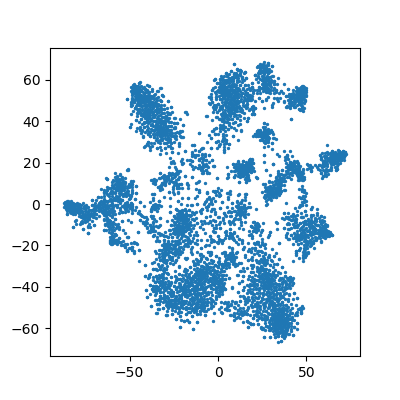

In [7]:
#Load the pre-computed tSNE coordinates
tSNE_data = np.stack((ds.ca._tSNE_1, ds.ca._tSNE_2))
df_tSNE = pd.DataFrame(data = tSNE_data, index=['tSNE1', 'tSNE2'], columns=ds.ca.CellID)

#NOTE: this includes all excluded cells. Their coordinates are (0,0)
#select included cells using the "Valid" attribute: df.loc[:, ds.ca.Valid == 1]

plt.figure(figsize=(4, 4))
plt.scatter(df_tSNE.loc['tSNE1', ds.ca.Valid == 1], df_tSNE.loc['tSNE2', ds.ca.Valid == 1], s=2)

## Re-run tSNE

In [ ]:
#Run a new tSNE

pca = PCA()
pc = pca.fit_transform(df_osmfish_totmol.loc[:,ds.ca.Valid == 1].T)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance PC')
plt.xlabel('Principle components')
plt.ylabel('explained variance')

In [ ]:
model = TSNE(n_iter=5000, perplexity=70, early_exaggeration=10)

tSNE_points= model.fit_transform(pc[:,:31])

df_tSNE = pd.DataFrame(data=tSNE_points.T, index=['tSNE1', 'tSNE2'], columns=ds.ca.CellID[ds.ca.Valid == 1])

plt.figure(figsize=(4, 4))
plt.scatter(df_tSNE.loc['tSNE1', ds.ca.Valid == 1], df_tSNE.loc['tSNE2', ds.ca.Valid == 1], s=2)

# Clustering

Clustering: Level_1, label: 0
    Daughter clusters labels: [2 3], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  []

Clustering: Level_2, label: 2
    Daughter clusters labels: [4 5], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  []

Clustering: Level_2, label: 3
    Daughter clusters labels: [6 7], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7]

Clustering: Level_3, label: 4
    Daughter clusters labels: [8 9], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7]

Clustering: Level_3, label: 5
    Daughter clusters labels: [10 11], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7, 11]

Clustering: Level_3, label: 6
    Daughter clusters labels: [12 13], evaluation of split: [3, 0]
    At least one of the 

Finished Clusters:  [7, 11, 13, 15, 17, 10, 25, 26, 27, 21, 33, 35, 37, 40, 43, 49, 51, 42, 55, 56, 57, 58, 59, 47, 63, 64, 65, 66, 68, 69, 71]

Clustering: Level_13, label: 72
    Daughter clusters labels: [74 75], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7, 11, 13, 15, 17, 10, 25, 26, 27, 21, 33, 35, 37, 40, 43, 49, 51, 42, 55, 56, 57, 58, 59, 47, 63, 64, 65, 66, 68, 69, 71, 75]

Clustering: Level_13, label: 73
    Daughter clusters labels: [76 77], evaluation of split: [2, 2]
    Different enriched genes, expression difference
Finished Clusters:  [7, 11, 13, 15, 17, 10, 25, 26, 27, 21, 33, 35, 37, 40, 43, 49, 51, 42, 55, 56, 57, 58, 59, 47, 63, 64, 65, 66, 68, 69, 71, 75, 76, 77]

Clustering: Level_14, label: 74
    Daughter clusters labels: [78 79], evaluation of split: [3, 0]
    At least one of the daughter clusters is too large
Finished Clusters:  [7, 11, 13, 15, 17, 10, 25, 26, 27, 21, 33, 35, 37, 40, 43, 49, 51, 42

<IPython.core.display.Javascript object>


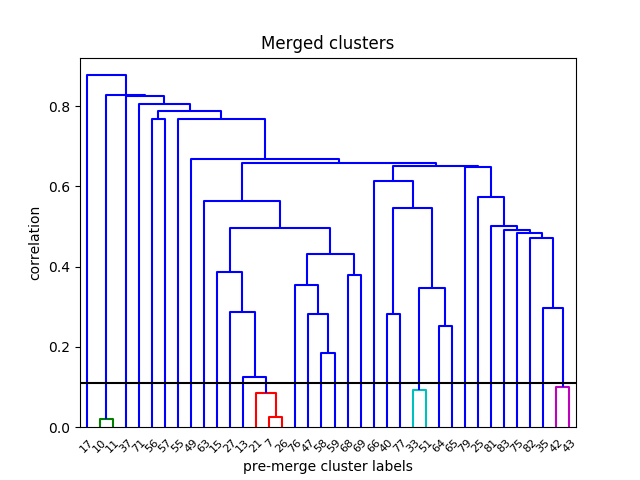

Merged clusters. Started with 38 clusters, merging results to 33 clusters.
Old label:  7 is converted to: 4
Old label: 10 is converted to: 1
Old label: 11 is converted to: 1
Old label: 13 is converted to: 5
Old label: 15 is converted to: 7
Old label: 17 is converted to: 33
Old label: 21 is converted to: 4
Old label: 25 is converted to: 27
Old label: 26 is converted to: 4
Old label: 27 is converted to: 6
Old label: 33 is converted to: 17
Old label: 35 is converted to: 22
Old label: 37 is converted to: 32
Old label: 40 is converted to: 15
Old label: 42 is converted to: 21
Old label: 43 is converted to: 21
Old label: 47 is converted to: 10
Old label: 49 is converted to: 29
Old label: 51 is converted to: 17
Old label: 55 is converted to: 30
Old label: 56 is converted to: 2
Old label: 57 is converted to: 3
Old label: 58 is converted to: 8
Old label: 59 is converted to: 9
Old label: 63 is converted to: 14
Old label: 64 is converted to: 18
Old label: 65 is converted to: 19
Old label: 66 is co

In [10]:
label_matrix_cluster = iterative_clustering(df_osmfish_totmol, 
                     expression_threshold = 550,
                     alpha = 0.1e-20,
                     min_clust_size = 15, 
                     dataset_fraction = 0.05,
                     allow_level_difference=False, 
                     max_cycles = 50,
                     post_merge_bool = True,
                     post_merge_cutoff = 0.11,
                     verbose=True)

#Select the final clustering result
last_level = label_matrix_cluster.iloc[-1]

#Get the labels in convenient formats
    #`cell_labels` = Dictionary coupling cellID with cluster label
    #`label_cells` = Dictionary coupling cluster labels with cellID
    #`cellID` = List of cellID in same order as labels
    #`labels` = List of cluster labels in same order as cells
    #`labels_a` = Same as "labels" but in numpy array
cell_labels, label_cells, cellID, labels, labels_a = gen_labels(df_osmfish_totmol, np.array(last_level))

In [13]:
#Remove bad clusters, with low expression and an unclear identity
bad_clusters = [11, 23]
label_matrix_cluster_clean = label_matrix_cluster.copy()
for i in bad_clusters:
    label_matrix_cluster_clean = label_matrix_cluster_clean.loc[:,label_matrix_cluster_clean.iloc[-1] != i]

#Make clean dataset
df_osmfish_totmol_clean = df_osmfish_totmol.loc[:, label_matrix_cluster_clean.columns]

#Generate labels again
last_level = label_matrix_cluster_clean.iloc[-1]
cell_labels, label_cells, cellID, labels, labels_a = gen_labels(df_osmfish_totmol_clean, np.array(last_level))

In [14]:
#Cluster names and colors
cluster_names = {
    18 : 'Inhibitory CP',
    17 : 'Inhibitory Crhbp',
    14 : 'Inhibitory Cnr1',
    19 : 'Inhibitory IC',
    15 : 'Inhibitory Kcnip2',
    16 : 'Inhibitory Pthlh',
    20 : 'Inhibitory Vip',
     9 : 'Pyramidal Cpne5',
     8 : 'Pyramidal L2-3',
    10 : 'Pyramidal L2-3 L5',
     6 : 'Pyramidal Kcnip2',
     5 : 'Pyramidal L3-4',
     4 : 'pyramidal L4',
    12 : 'Pyramidal L5',
     1 : 'Pyramidal L6',
    13 : 'Hippocampus',
     3 : 'Astrocyte Gfap',
     2 : 'Astrocyte Mfge8',
    32 : 'Oligodendrocyte Precursor cells',
    33 : 'Oligodendrocyte COP',
    30 : 'Oligodendrocyte NF',
    22 : 'Oligodendrocyte MF',
    21 : 'Oligodendrocyte Mature',
    28 : 'Perivascular Macrophages',
    29 : 'Microglia',
    24 : 'C. Plexus',
    27 : 'Ependymal',
    31 : 'Pericytes',
     7 : 'Endothelial',
    26 : 'Endothelial 1',
    25 : 'Vascular Smooth Muscle'}

cluster_names_short = {
    18 : 'Inh CP',
    17 : 'Inhib Crhbp',
    14 : 'Inhib Cnr1',
    19 : 'Inhib IC',
    15 : 'Inhib Kcnip2',
    16 : 'Inhib Pthlh',
    20 : 'Inhib Vip',
     9 : 'Py Cpne5',
     8 : 'Py L2-3',
    10 : 'Py L2-3 L5',
     6 : 'Py Kcnip2',
     5 : 'Pyl L3-4',
     4 : 'py L4',
    12 : 'Py L5',
     1 : 'Py L6',
    13 : 'Hippocampus',
     3 : 'Astro Gfap',
     2 : 'Astro Mfge8',
    32 : 'OPC',
    33 : 'Oligo COP',
    30 : 'Oligo NF',
    22 : 'Oligo MF',
    21 : 'Oligo Mature',
    28 : 'PVM',
    29 : 'Microglia',
    24 : 'C. Plexus',
    27 : 'Ependymal',
    31 : 'Pericytes',
     7 : 'Endothelial',
    26 : 'Endothelial 1',
    25 : 'VSM'}

cluster_colors = {
    18 : '#9b067d',
    17 : '#9805cc',
    14 : '#ca4479',
    19 : '#ff49b0',
    15 : '#af7efe',
    16 : '#4e14a6',
    20 : '#7759a4',
     9 : '#3e4198',
     8 : '#0ab4e4',
    10 : '#1e6a87',
     6 : '#6787d6',
     5 : '#004dba',
     4 : '#78edff',
     1 : '#027fd0',
    13 : '#004b71',
    12 : '#0a9fb4',
     3 : '#de4726',
     2 : '#f69149',
    32 : '#b3ee3d',
    33 : '#5dd73d',
    30 : '#64a44e',
    22 : '#2f7449',
    21 : '#285528',
    28 : '#762a14',
    29 : '#a7623d',
    24 : '#21b183',
    27 : '#fadf0b',
    31 : '#f8c495',
     7 : '#f81919',
    26 : '#f05556',
    25 : '#aec470',
    
    11: '#6c6b6b',
    23: '#6c6b6b',
}

df used for plot: df_osmfish_totmol_clean
Order of clusters: [18, 17, 14, 19, 15, 16, 20, 9, 8, 10, 6, 5, 4, 12, 1, 13, 3, 2, 32, 33, 30, 22, 21, 28, 29, 24, 27, 31, 7, 26, 25]


<IPython.core.display.Javascript object>


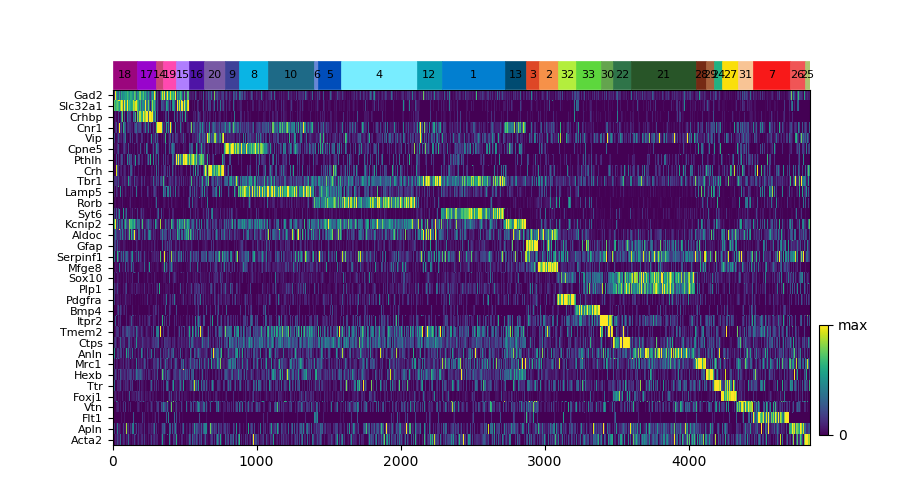

In [15]:
#Plot the heat map
cluster_sort = [18,17,14,19,15,16,20, #Inhibitory
                9,8,10,6,5,4,12,1,13, #Excitatory
                3,2, #Astrocytes
                32,33,30,22,21, #Oligodendrocytes
                28,29, #Immune
                24,27, #Ventricle
                31,7,26,25] #Blood

heat_map(df_osmfish_totmol_clean, labels, cluster_colors=cluster_colors, 
         cluster_number=True, sort = cluster_sort, save=False, name='')

<IPython.core.display.Javascript object>


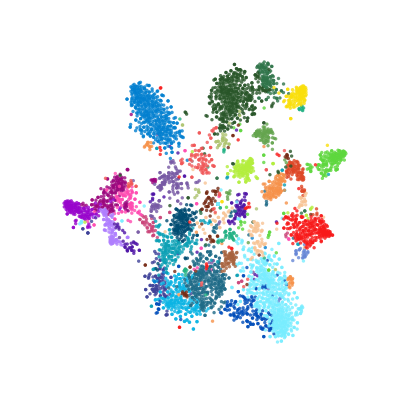

In [16]:
#plot the clusters on the tSNE.
def plot_tSNE_clusters(df_tSNE, labels, cluster_colors = None, save=False, name=None):
    """
    Plot the tSNE in different colors according to the labels.
    Input:
    `df_tSNE`(Pandas dataframe): df with tSNE coordinates in rows, named: "tSNE1"
        and "tSNE2".
    `labels`(array/list): Array of cluster labels, in the same order as the 
        "df_tSNE" columns.
    `cluster_colors`(dict): Optinal. Dictionary with predefined colors. If "None" 
        it will default to the prism colormap
    `save`(bool): Save the image as png with 600dpi.
    `name`(string): Name to use for saving. 
    
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    if cluster_colors == None:
        ax.scatter(df_tSNE.loc['tSNE1'], df_tSNE.loc['tSNE2'], s=6, alpha=0.8, lw=0,
               c= plt.cm.prism(labels_a/max(labels)))
    else:
        ax.scatter(df_tSNE.loc['tSNE1'], df_tSNE.loc['tSNE2'], s=6, alpha=0.8, lw=0,
                   c= [cluster_colors[i] for i in labels])
    ax.set_axis_off()
    
    if save == True:
        plt.savefig('{}.png'.format(name), dpi=600)

plot_tSNE_clusters( df_tSNE, labels_a, cluster_colors=cluster_colors, save=False, name='')

<IPython.core.display.Javascript object>


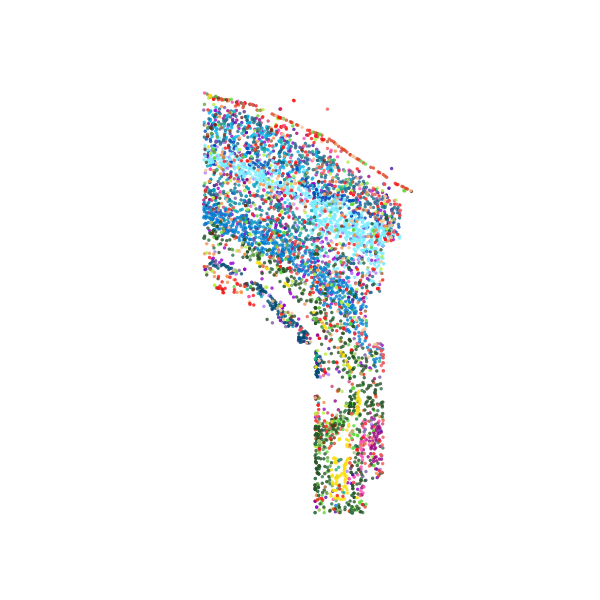

In [17]:
#plot the clusters on the centroids of the cells.
def plot_tissue(df, df_coordinates, labels, cluster_colors=None, save=False, name=None):
    """
    Plot the centroids of the cells with the colors according to the labels.
    Input:
    `df`(Pandas dataframe): df to which the labels correspond.
    `df_coordinates`(Pandas dataframe): df with cells coordinates in rows, named:
        "X" and "Y".
    `labels`(array): Array of cluster labels, in the same order as the "df_tSNE"
        columns.
    `cluster_colors`(dict): Optinal. Dictionary with predefined colors. If "None" 
        it will default to the prism colormap
    `save`(bool): Save the image as png with 600dpi.
    `name`(string): Name to use for saving. 
    
    """
    fig, ax = plt.subplots(figsize=(6,6))
    
    df_coordinates = df_coordinates.loc[:, df.columns]
    
    if cluster_colors == None:
        ax.scatter(df_coordinates.loc['X'], df_coordinates.loc['Y'], s=6, alpha=0.8, lw=0,
               c= plt.cm.prism(labels_a/max(labels)))
    else:
        ax.scatter(df_coordinates.loc['X'], df_coordinates.loc['Y'], s=6, alpha=0.8, lw=0,
                   c= [cluster_colors[i] for i in labels])
    
    ax.axis('equal')
    ax.set_axis_off()
    
    if save == True:
        plt.savefig('{}.png'.format(name), dpi=600)
        
        
plot_tissue(df_osmfish_totmol_clean, df_coordinates, labels_a, cluster_colors=cluster_colors)

# Infer regions

In [18]:
#Select clusters that are considered to have a spatial distribution in confined areas.
#Calculate Ripley's K estimate for the distribution of all clusters. 
df_coordinates_clean = df_coordinates.loc[:, df_osmfish_totmol_clean.columns]
x_min = df_coordinates_clean.loc['X'].min()
x_max = df_coordinates_clean.loc['X'].max()
y_min = df_coordinates_clean.loc['Y'].min()
y_max = df_coordinates_clean.loc['Y'].max()
area = ((x_max-x_min)*(y_max-y_min))
Kest = RipleysKEstimator(area, x_max, y_max, x_min, y_min)
radii = np.linspace(1000,20000, 100)

RK_750 = []
for i in np.sort(np.unique(labels_a)):
    filt = labels_a == i
    estimate =  Kest(data=np.array(df_coordinates_clean.loc[:,filt].T), radii=radii, mode='none')
    RK_750.append(estimate[np.argmin(np.abs(radii - 750))]) 


<IPython.core.display.Javascript object>


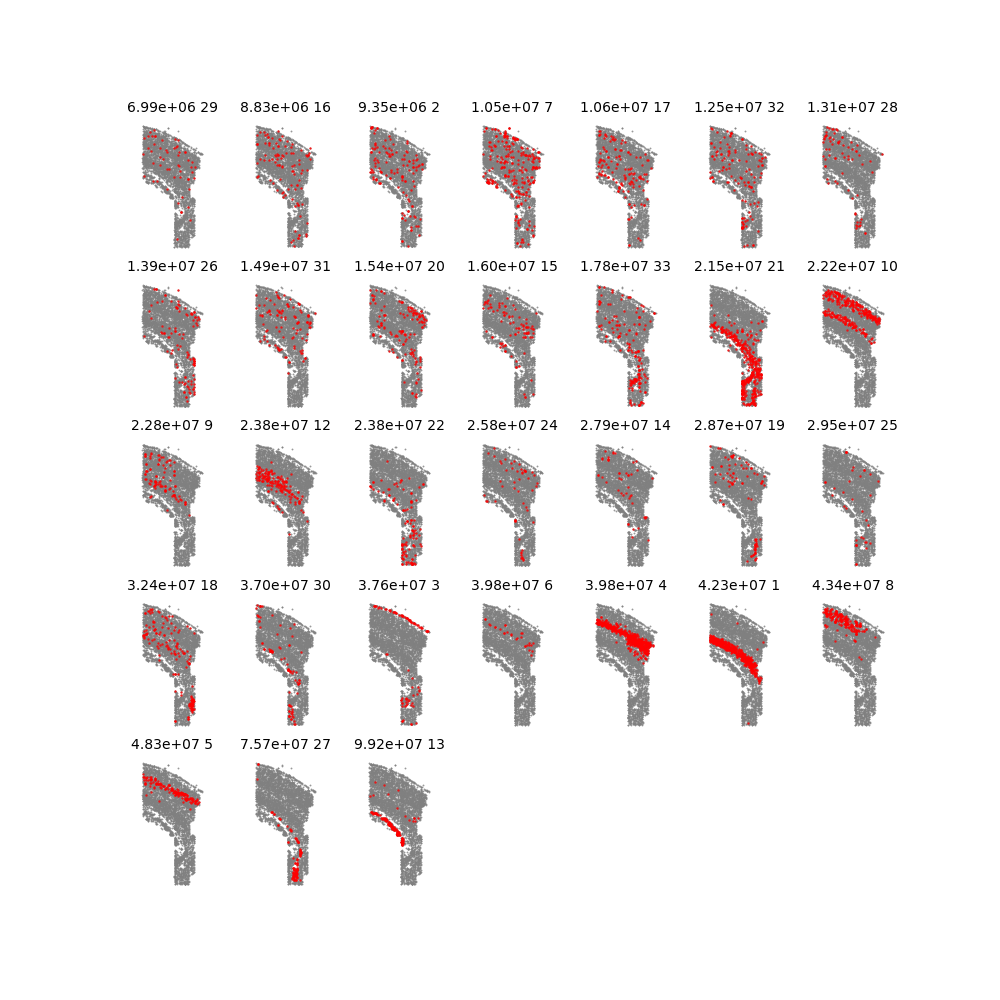

In [20]:
def plot_centroid_of_interest(df_coordinates, cells_of_interest, size_factor=1, ax = None, save=False, name=None):
    """
    Plot the centroids of all cells in grey, and the cells of interest in red.
    Input:
    `df_coordinates`(Pandas dataframe): df with cells coordinates in rows, named:
        "X" and "Y".
    `cells_of_interest`(str,ID list, Bool array): Name of cell, list of cellID's
        or array of bools to filter the df_coordinates.
    `size_factor`(float): scale the dots using this factor.
    `ax`(matplotlib ax object): Will plot on the provided ax. Otherwise makes a
        new figure
    `save`(bool): Save the image as png with 600dpi.
    `name`(string): Name to use for saving. 
    
    """
    if ax == None:
        fig, ax = plt.subplots(figsize=(6,6))
    
    ax.scatter(df_coordinates.loc['X'], df_coordinates.loc['Y'], s=6 * size_factor, 
               alpha=0.8, lw=0, c='grey')
    ax.scatter(df_coordinates.loc['X', cells_of_interest], df_coordinates.loc['Y', cells_of_interest], 
               s=10 * size_factor, alpha=0.8, lw=0, c='red')
    
    ax.axis('equal')
    ax.set_axis_off()

plt.figure(figsize=(10,10))
n_clusters = len(np.unique(labels_a))
gs = plt.GridSpec(5, int(n_clusters/5) + (n_clusters % 5 > 0))

RK_dist = RK_750

for i, c in enumerate([np.unique(labels_a)[i] for i in np.argsort(RK_dist)]):
    ax = plt.subplot(gs[i])
    filt = labels_a == c
    plot_centroid_of_interest(df_coordinates_clean, filt,size_factor=0.3, ax = ax, save=False, name=None)
    ax.set_title('{} {}'.format("{:.2e}".format(RK_dist[np.argsort(RK_dist)[i]]), c), fontsize=10)

In [21]:
#Select the clusters that are regionalized.
RK_cutoff = 2e7
spatial_clusters = [np.unique(labels_a)[n] for n,i in enumerate(RK_750) if i>RK_cutoff]

In [23]:
label_matrix_regions = regionalization(df_coordinates_clean, 
                              labels_a, 
                              20, 
                              cycles=18, 
                              included_labels = spatial_clusters,
                              max_dist=[1000,1000,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1500,1500],
                              percentage_cutoff = 50, 
                              reset_label_round = [], 
                              reset_count_cutoff=200, 
                              reset_to_9999 = True, 
                              merge_labels=False, 
                              remove_islands = True, 
                              remove_island_round = [5,7,10,16],
                              island_max_dist = 3000,  
                              island_minimal_group=75, 
                              post_split=True,
                              force_id = True, 
                              force_id_cutoff = 20, 
                              giving_back_round=[14])

Removing islands
Completed removal of islands
Removing islands
Completed removal of islands
Removing islands
Completed removal of islands
Giving back
Completed giving back
Removing islands
Completed removal of islands
Post_split 10, new label: 34
Post_split 10, new label: 35
Post_split 9999, new label: 36
Post_split 9999, new label: 37
Split disconnected areas with same label. Data in "post_split" row
Removed labels with less than 20 cells. forced the id of 5 cells with labels: [36, 37, 9999]. 
        Data in "force_id" row


force_id


<IPython.core.display.Javascript object>


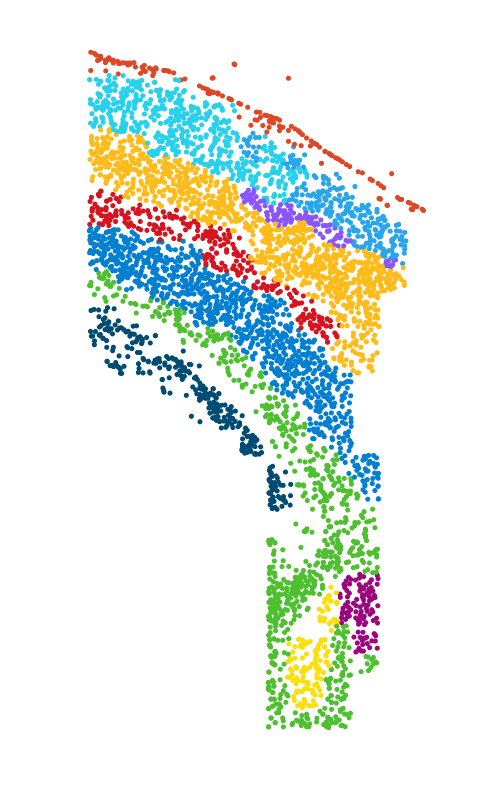

Number of labels: 11
Counter({1: 1015, 4: 1002, 21: 877, 8: 549, 13: 322, 35: 295, 34: 254, 3: 159, 5: 131, 27: 129, 18: 106})


In [24]:
region_colors = {
    1:'#027fd0',
    3:'#de4726',
    4:'#ffbb19',
    5:'#8a55ff',
    8:'#28d1eb',
    13:'#004b71',
    18:'#9b067d',
    21:'#4ec030',
    27:'#fadf0c',
    34:'#28a5eb',
    35:'#d61420',
    }

def plot_regions(cell_coordinates, label_matrix, level, region_colors=None):
    """
    Plot the centroids of the cells with the color of their region.
    Input:
    `df_coordinates`(Pandas dataframe): df with cells coordinates in rows, named:
        "X" and "Y".
    `label_matrix`(Pandas dataframe): output of the regionalization function.
    `level`(int): Level of the 'label_matrix' to plot. If input is -1 it will 
        take the last level, i.e. the final result.
    `region_colors`(dict): Dictionary with colors for each label.
    
    """
    if level == -1:
        level = label_matrix.shape[0] - 1
    
    print(label_matrix.index[level])
    fig, ax = plt.subplots(figsize=(5,8))
    
    
    
    if region_colors == None:
        c_labels = [list(np.unique(label_matrix.iloc[level])).index(i) for i in label_matrix.iloc[level]]
    else:
        c_labels = [region_colors[i] for i in label_matrix.iloc[level]]
    
    ax.scatter(cell_coordinates.loc['X'], cell_coordinates.loc['Y'], s=7,
              c = c_labels, cmap = 'spectral') 
    ax.set_aspect('equal')
    ax.set_axis_off()
    print('Number of labels: {}'.format(len(np.unique(label_matrix.iloc[level]))))
    print(Counter(label_matrix.iloc[level]))
    plt.tight_layout()

plot_regions(df_coordinates_clean, label_matrix_regions, -1, region_colors=region_colors) 

# Spatial relationships

In [25]:
#For each cell, find the closest neighbouring cell of all cell types
#Add the distances between these cells to a dictionary with distances 
#for each possible cluster permutation (including itselve)

#Build the nearest neighbour tree in micro meter
    #The pixel size is 0.065 um per pixel
df_coordinates_clean_um = df_coordinates_clean * 0.065
tree_um = scipy.spatial.KDTree(df_coordinates_clean_um.T)

#Make a dict to store all the cell type permutations as keys and all the distances in a list.
permutations = [i for i in permute(np.unique(labels_a), 2)]
permutations_distance_dict = {}
for i in permutations:
    permutations_distance_dict[i] = []
for i in np.unique(labels_a):
    permutations_distance_dict[(i,i)] = []

#Loop over all cells
unique_labels = np.unique(labels_a)
n_cells = df_osmfish_totmol_clean.shape[1]
for cell in df_osmfish_totmol_clean.columns:
    c_label = cell_labels[cell]
    #Distance of all cells
    dist = tree_um.query(df_coordinates_clean_um.loc[:,cell], k = n_cells)
    #Trim so that it does not find the queried cell
    trim_n = n_cells - len(np.trim_zeros(dist[0], trim='f'))
    #Make list of the labels of the cells sorted by distance
    nearest_labels = [labels_a[i] for i in dist[1][trim_n:]]
    #List of distances sorted
    distances = dist[0][trim_n:]
    
    #use the closest cells to find the closest neighbour 
    for l in unique_labels:
        permutations_distance_dict[(c_label, l)].append(distances[nearest_labels.index(l)])


cluster_order = [18,17,14,19,15,16,20,
                9,8,10,6,5,4,12,1,13,
                3,2,
                32,33,30,22,21,
                28,29,24,27,31,7,26,25]

#Calculate the mean distances
distance_matrix_permutations_mean = pd.DataFrame(data = np.zeros((len(cluster_order), len(cluster_order))), index=cluster_order, columns=cluster_order)
#counter=0
for r in cluster_order:
    for c in cluster_order:
        distance_matrix_permutations_mean.loc[r,c] = np.mean(permutations_distance_dict[r,c])     

<IPython.core.display.Javascript object>


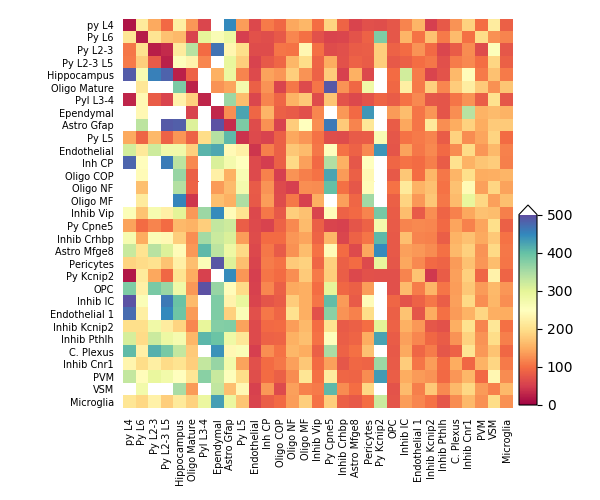

/home/lars/programs/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [26]:
def plot_distance_matrix(dm):
    """
    Plot the distance matrix. 
    Read it like: The distance of the row cell type to the column cell type.
    Matrix will be sorted on auto-associaltion, which is the diagonal
    Input:
    `dm`(Pandas dataframe): df with the cells types on the index and column with
        the mean distance of the index type to the column type as values.
    
    """
    # Sort on self association
    self_dist = [dm.loc[i,i] for i in dm.index]
    sort_self_association = [dm.index[i] for i in np.argsort(self_dist)]
    dm = dm.loc[sort_self_association, sort_self_association]

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.pcolormesh(dm, cmap='Spectral', vmin=0, vmax=500)
    #im.cmap.set_under('black', alpha=1) 
    im.cmap.set_over('white', alpha=1)

    cax = fig.add_axes([0.865, 0.19,  0.03, 0.4])
    colorbar = fig.colorbar(im, cax=cax, extend='max',ticks=[0,100,200,300,400,500], )
    colorbar.set_ticklabels(['0','100','200','300','400','500'])

    ax.set_aspect('equal')

    y_pos = np.arange(len(cluster_order))
    x_pos = np.arange(len(cluster_order))
    ax.set_xticks(x_pos+0.5)
    ax.set_xticklabels([cluster_names_short[i] for i in dm.columns], rotation='vertical', fontsize=7)
    ax.set_yticks(y_pos+0.5)
    ax.set_yticklabels([cluster_names_short[i] for i in dm.columns], fontsize=7);
    ax.invert_yaxis()

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    plt.tight_layout()


plot_distance_matrix(distance_matrix_permutations_mean)
